# Маркетинговые затраты Яндекс.Афиши и предложения по их оптимизации

1. [Задача проекта](#start)
3. [Подготовка данных к анализу](#prepare)
4. [Исследовательский анализ данных](#investigation)
    * [Распределение по девайсу](#device_stats)
    * [Распределение по источнику](#source_stats)
    * [Посещаемость](#visit)
     * [Количество пользователей в день, неделю, месяц](#visit_dau)
     * [Количество сессий в день](#visit_session)
     * [Длительность одной сессии ](#visit_duration)
     * [Процент удержания пользователей](#visit_retention)
    * [Продажи](#orders)
     * [Когда люди начинают покупать](#orders_delta)
     * [Количество покупок за период](#orders_count)
     * [Средний чек](#orders_mean)
     * [Доход с пользователя (LTV)](#orders_ltv)
    * [Маркетинг](#marketing)
     * [Траты суммарные / на каждый источник / по времени ](#marketing_costs)
     * [Cтоимость привлечения одного покупателя из каждого источника (CAC)](#marketing_cac)
     * [Окупаемость расходов (ROI)](#marketing_roi)
5. [Выводы](#resume)
6. [Рекомендации](#recommendations)

# Задача проекта <a id="start"></a>
В этом отчете мы посмотрим, 
- как люди пользуются Яндекс.Афишей,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

На основе результатов мы сформируем рекомендации по оптимизации расходов в отделе маркетинга.

 # Подготовка данных к анализу  <a id="prepare"></a>

In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

## Visits

In [2]:
visits=pd.read_csv('visits_log.csv')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
visits.sample()

,Device,End Ts,Source Id,Start Ts,Uid
50941,desktop,2017-07-07 19:10:00,3,2017-07-07 19:10:00,5641009350469106008


Приведем названия колонок к нижнему регистру и заменим пробелы на нижнее подчеркивание для удобства в следующих запросах.

In [4]:
visits.columns = map(str.lower, visits.columns)
visits.columns=visits.columns.str.replace(' ','_')
visits.sample(3)

,device,end_ts,source_id,start_ts,uid
203974,desktop,2017-12-23 13:06:00,2,2017-12-23 12:50:00,8827240833506355343
263492,desktop,2018-02-25 20:07:00,4,2018-02-25 19:47:00,3851873641123472216
21683,desktop,2017-07-11 16:29:00,5,2017-07-11 16:28:00,11894978548476709776


Приведем колонки с датой к формату даты.

In [5]:
visits['end_ts']=pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts']=pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [6]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

Проделаем то же самое с другими таблицами

## Orders

In [7]:
orders=pd.read_csv('orders_log.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [8]:
orders.columns = map(str.lower, orders.columns)
orders.columns=orders.columns.str.replace(' ','_')
orders.sample(3)

,buy_ts,revenue,uid
13118,2017-10-16 21:19:00,0.61,1082163778882750282
18660,2017-11-21 09:43:00,3.67,4209497916017636912
32667,2018-02-02 20:00:00,1.53,8132269060137383590


In [9]:
orders['buy_ts']=pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [10]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

## Costs

In [11]:
costs=pd.read_csv('costs.csv')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [12]:
costs.columns = map(str.lower, costs.columns)
costs.columns = map(str.lower, costs.columns)
costs.sample(3)

,source_id,dt,costs
6,1,2017-06-07,40.59
2239,10,2017-07-31,12.10
2297,10,2017-09-27,17.71


In [13]:
costs['dt']=pd.to_datetime(costs['dt'], format='%Y-%m-%d')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [14]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

In [15]:
costs=costs.rename(columns={'dt':'obtain_date'})
costs.sample()

,source_id,obtain_date,costs
568,2,2017-12-23,145.14


## Users

Создадим таблицу с юзерами, добавим даты их первого посещения, источник визита и девайс. 

In [16]:
users=(visits.sort_values(by=['uid','start_ts']).groupby('uid')
             .agg({'start_ts':'first','source_id':'first','device':'first'})
      .rename(columns={'start_ts':'obtain_ts'}))
users['obtain_date']=users['obtain_ts'].dt.date
users['obtain_month']=users['obtain_ts'].astype('datetime64[M]')
users=(users.reset_index().set_index(['source_id','obtain_date'])
       .join(costs.set_index(['source_id','obtain_date']), how='left'))
users.head()

uid           obtain_ts   device  \
source_id obtain_date                                                     
1         2017-06-01    469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01    618675438905551322 2017-06-01 02:37:00    touch   
          2017-06-01   1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01   1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01   1548840741623289234 2017-06-01 01:18:00  desktop   

                      obtain_month  costs  
source_id obtain_date                      
1         2017-06-01    2017-06-01   75.2  
          2017-06-01    2017-06-01   75.2  
          2017-06-01    2017-06-01   75.2  
          2017-06-01    2017-06-01   75.2  
          2017-06-01    2017-06-01   75.2

Добавим стоимость каждого пользователя. 

In [17]:
user_cost=(users.groupby(['source_id','obtain_date']).agg({'device':'count','costs':'mean'})
           .rename(columns={'device':'users'}))
user_cost['obtain_cost']=user_cost['costs']/user_cost['users']
users=users.join(user_cost[['obtain_cost']], how = 'left')
users=users.reset_index().set_index('uid')[['obtain_ts','obtain_date','obtain_month','source_id','device','obtain_cost']]
users.head()

,obtain_ts,obtain_date,obtain_month,source_id,device,obtain_cost
uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6


# Исследовательский анализ данных <a id="investigation"></a>

## Распределение по девайсу <a id="device_stats"></a>

In [18]:
dimenstion_d=['device']
cohorts_d=users.groupby(dimenstion_d).agg({'source_id':'count'}).rename(columns={'source_id':'cohort_d_size'})
cohorts_d  

,cohort_d_size
device,
desktop,160795
touch,67374


<div style="border:solid black 2px; padding: 20px"> Афишей пользуются с десктопов в 2.5 раза больше чем с телефонов и планшетов. 

## Распределение по источнику <a id="source_stats"></a>

In [19]:
dimenstion_s=['source_id']
cohorts_s=users.groupby(dimenstion_s).agg({'device':'count'}).rename(columns={'device':'cohort_s_size'})
cohorts_s.sort_values(by='cohort_s_size',ascending=False) 

,cohort_s_size
source_id,
4,72346
3,66116
5,49237
2,17616
1,9469
10,6903
9,6448
7,32
6,2


<div style="border:solid black 2px; padding: 20px"> Источники 4,3 и 5 - самые популярные, реже всего приходят из источников 6 и 7. 

## Посещаемость <a id="visit"></a>

### Количество пользователей в день, неделю, месяц <a id="visit_dau"></a>

In [20]:
visits.sample()

,device,end_ts,source_id,start_ts,uid
246823,touch,2018-04-05 12:06:00,4,2018-04-05 12:05:00,2564596516663532013


Выделим год, месяц, день и дату без времени из таблицы с визитами. 

In [21]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
visits['session_cal_month'] = visits['start_ts'].astype('datetime64[M]')
visits.sample()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_cal_month
101048,touch,2018-04-20 09:06:00,1,2018-04-20 09:04:00,1028042286614232755,2018,4,16,2018-04-20,2018-04-01


Количество посетителей в месяц:

In [22]:
mau_total=visits.groupby(['session_year','session_month']).agg({'uid':'nunique'}).mean()
mau_total

uid    23228.416667
dtype: float64

Количество посетителей в неделю:

In [23]:
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
wau_total

uid    5716.245283
dtype: float64

Количество посетителей в день:

In [24]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
dau_total

uid    907.991758
dtype: float64

Регулярность использования ресурса в неделю в процентах:

In [25]:
sticky_wau=dau_total/wau_total*100
sticky_wau

uid    15.884409
dtype: float64

Регулярность использования ресурса в месяц в процентах:

In [26]:
sticky_mau=dau_total/mau_total*100
sticky_mau

uid    3.90897
dtype: float64

<div style="border:solid black 2px; padding: 20px"> В среднем ресурс посещают 23228 человека в месяц, 5716 - каждую неделю, 908 - ежедневно. 
    
Степень вовлеченности: каждый день 4% от аудитории за месяц и 15% от аудитории за неделю пользуются ресурсом. Этот показатель не очень высокий (минимально возможные - 3% месячный коэффициент и 14% - недельный).

In [27]:
visits.pivot_table(index='session_cal_month',columns='device', values='uid', aggfunc='count')

device,desktop,touch
session_cal_month,,
2017-06-01,12358,4147
2017-07-01,12950,4878
2017-08-01,10854,3501
2017-09-01,17356,6551
2017-10-01,27392,10511
2017-11-01,32917,11052
2017-12-01,31112,10871
2018-01-01,26577,10362
2018-02-01,27077,10105


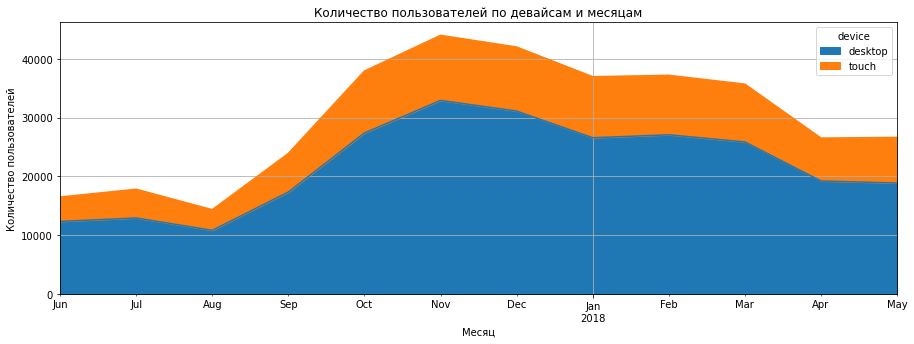

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
platforms=['desktop','touch']
(
visits
    .query('device.isin(@platforms)', engine='python')
    .pivot_table(index='session_cal_month',columns='device', values='uid', aggfunc='count')
    .plot(ax=ax,kind='area')
)
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей по девайсам и месяцам')
plt.grid(True)
plt.xlim
plt.show()

<div style="border:solid black 2px; padding: 20px"> На сайт чаще заходят с десктопов, чем с тачскринов. Пик посещаемости был в конце осени-начале зимы - больше 40 000 посетителей (гулять на улице холодно, на носу всякие праздники). 

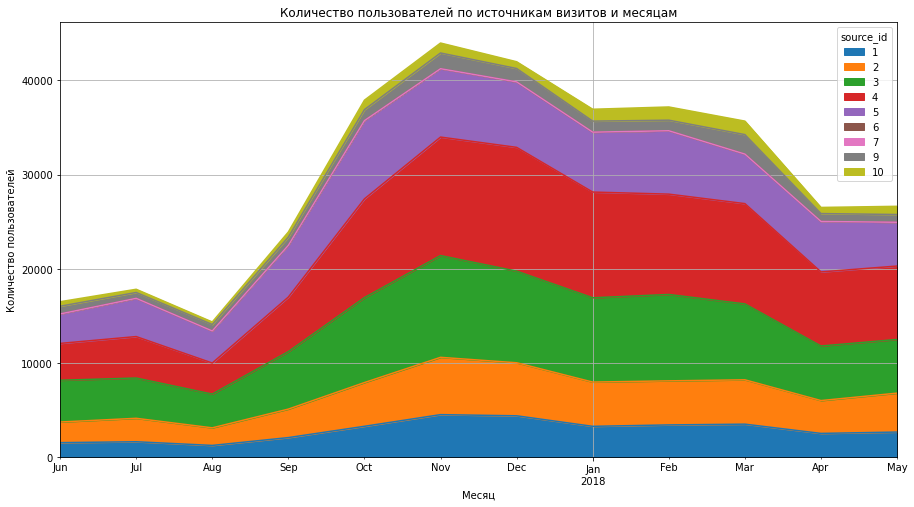

In [29]:
fig, ax = plt.subplots(figsize=(15,8))
(
visits
    .pivot_table(index='session_cal_month',columns='source_id', values='uid', aggfunc='count')
    .plot(ax=ax,kind='area')
)
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей по источникам визитов и месяцам')
plt.grid(True)
plt.xlim
plt.show()

<div style="border:solid black 2px; padding: 20px"> Больше всего посетителей приходят с источников 3,4,5. И распределение сохраняется между источниками на всем временном отрезке. 

### Количество сессий в день <a id="visit_session"></a>

In [30]:
visits.sample()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_cal_month
123653,desktop,2017-11-24 22:22:00,2,2017-11-24 21:49:00,384150593749785632,2017,11,47,2017-11-24,2017-11-01


In [31]:
day_count = visits.groupby('session_date').agg({'uid': 'count'}).mean()
day_count

uid    987.362637
dtype: float64

<div style="border:solid black 2px; padding: 20px">  В среднем на афише бывает 987 сессий в день. 

Посмотрим распределние по девайсам.

In [32]:
day_count_d=visits.groupby(['session_date','device']).agg({'uid': ['count']})
day_count_d.columns = ['n_sessions']
day_count_d=(day_count_d
             .reset_index()
             .pivot_table(index='session_date',columns='device', values='n_sessions', aggfunc='mean')
            )
day_count_d

device,desktop,touch
session_date,,
2017-06-01,501.0,163.0
2017-06-02,498.0,160.0
2017-06-03,329.0,148.0
2017-06-04,349.0,161.0
2017-06-05,693.0,200.0
...,...,...
2018-05-27,426.0,246.0
2018-05-28,835.0,321.0
2018-05-29,751.0,284.0


In [33]:
day_count_d.reset_index().describe().T.sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
device,,,,,,,,
desktop,364.0,721.337912,322.327697,1.0,457.25,711.0,961.5,3152.0
touch,363.0,266.757576,110.862623,47.0,181.00,278.0,337.0,890.0


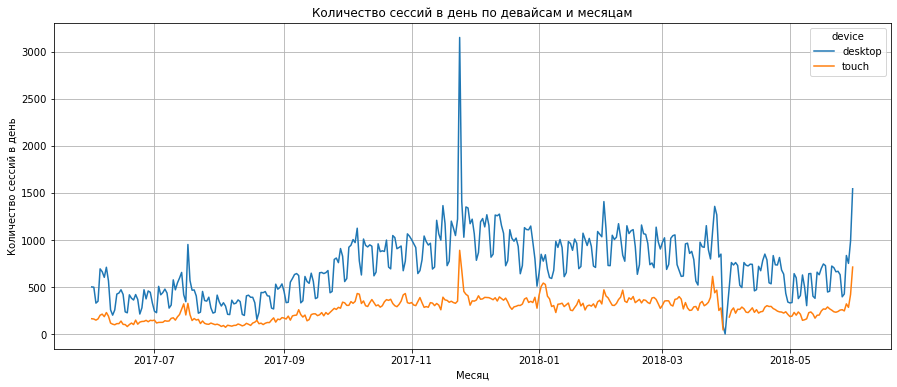

In [34]:
day_count_d.plot(figsize=(15,6))
plt.xlabel('Месяц')
plt.ylabel('Количество сессий в день')
plt.title('Количество сессий в день по девайсам и месяцам')
plt.grid(True)
plt.xlim
plt.show()

<div style="border:solid black 2px; padding: 20px"> В среднем, в день бывает 720 сессий с десктопов и 270 с  тачскринов. 

Распределние по источникам. 

In [35]:
day_count_s=visits.groupby(['session_date','source_id']).agg({'uid': ['count']})
day_count_s.columns = ['n_sessions']
day_count_s=(day_count_s
            .reset_index()
            .pivot_table(index='session_date',columns='source_id', values='n_sessions', aggfunc='mean')
            )
day_count_s

source_id,1,2,3,4,5,6,7,9,10
session_date,,,,,,,,,
2017-06-01,70.0,85.0,185.0,141.0,122.0,NaN,NaN,52.0,9.0
2017-06-02,60.0,98.0,181.0,160.0,123.0,NaN,NaN,15.0,21.0
2017-06-03,40.0,64.0,124.0,112.0,91.0,NaN,NaN,22.0,24.0
2017-06-04,51.0,59.0,141.0,115.0,110.0,NaN,NaN,15.0,19.0
2017-06-05,86.0,108.0,269.0,175.0,141.0,NaN,NaN,78.0,36.0
...,...,...,...,...,...,...,...,...,...
2018-05-27,67.0,90.0,145.0,241.0,112.0,NaN,NaN,7.0,10.0
2018-05-28,115.0,141.0,232.0,358.0,205.0,NaN,NaN,60.0,45.0
2018-05-29,113.0,151.0,259.0,288.0,164.0,NaN,NaN,28.0,32.0


In [36]:
day_count_s.reset_index().describe().T.sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
source_id,,,,,,,,
4,363.0,280.424242,124.095297,32.0,171.5,300.0,376.5,783.0
3,363.0,235.840220,98.626321,32.0,154.0,238.0,305.0,965.0
5,363.0,184.311295,68.697387,33.0,134.5,181.0,227.0,427.0
2,363.0,131.201102,65.523610,18.0,84.5,131.0,163.5,649.0
1,364.0,93.739011,51.809680,1.0,59.0,91.0,120.0,615.0
9,363.0,36.575758,47.929353,1.0,9.5,22.0,52.5,567.0
10,363.0,27.617080,19.365329,1.0,14.0,23.0,37.0,135.0
7,34.0,1.058824,0.238833,1.0,1.0,1.0,1.0,2.0
6,6.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


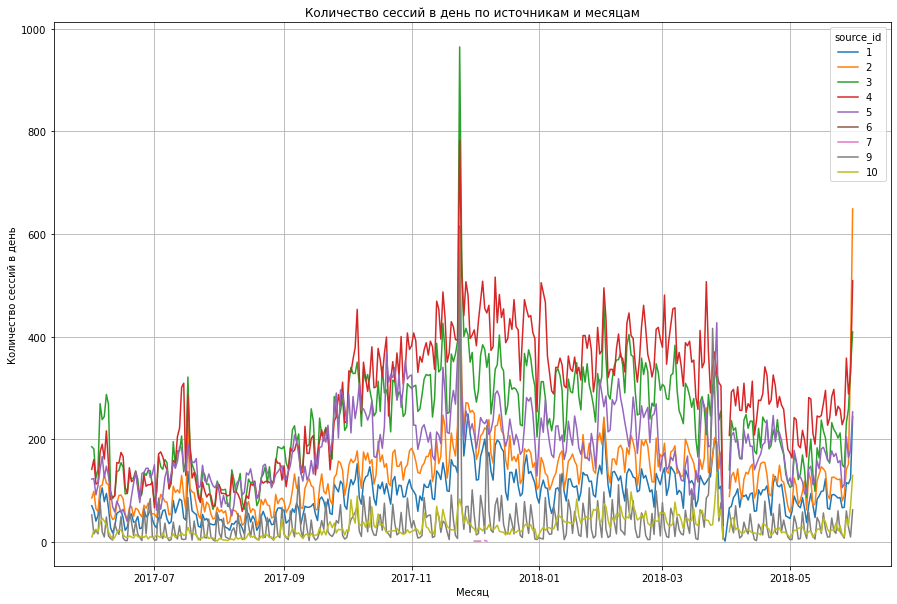

In [37]:
day_count_s.plot(figsize=(15,10))
plt.xlabel('Месяц')
plt.ylabel('Количество сессий в день')
plt.title('Количество сессий в день по источникам и месяцам')
plt.grid(True)
plt.xlim
plt.show()

<div style="border:solid black 2px; padding: 20px"> Больше всего сессий сделано пользователями, пришедших из источников  3 и 4. 

Посмотрим, сколько сессий приходится на одного посетителя в месяц.

In [38]:
sessions_per_user_d = visits.groupby(['session_cal_month','device']).agg({'uid': ['count','nunique']})
sessions_per_user_d.columns = ['n_sessions', 'n_users']
sessions_per_user_d['sessions_per_user'] = sessions_per_user_d['n_sessions'] / sessions_per_user_d['n_users']
sessions_per_user_d

n_sessions  n_users  sessions_per_user
session_cal_month device                                         
2017-06-01        desktop       12358     9761           1.266059
                  touch          4147     3655           1.134610
2017-07-01        desktop       12950    10145           1.276491
                  touch          4878     4223           1.155103
2017-08-01        desktop       10854     8611           1.260481
                  touch          3501     3132           1.117816
2017-09-01        desktop       17356    13509           1.284773
                  touch          6551     5679           1.153548
2017-10-01        desktop       27392    21286           1.286855
                  touch         10511     8856           1.186879
2017-11-01        desktop       32917    24439           1.346905
                  touch         11052     8913           1.239987
2017-12-01        desktop       31112    23294           1.335623
                  touch         10871     8785           1.237450
2018-01-01        desktop       26577    20350           1.305995
                  touch         10362     8741           1.185448
2018-02-01        desktop       27077    20574           1.316079
                  touch         10105     8590           1.176368
2018-03-01        desktop       25861    19574           1.321191
                  touch          9818     8303           1.182464
2018-04-01        desktop       19231    14844           1.295540
                  touch          7284     6387           1.140442
2018-05-01        desktop       18882    14312           1.319312
                  touch          7753     6647           1.166391

In [39]:
sessions_per_user_d['sessions_per_user'].mean()

1.2371587237288595

<div style="border:solid black 2px; padding: 20px">  Поceтитель бывает на афише в среднем чуть больше одного раза в месяц. 

Посмотрим распределение по девайсу и источникам.

In [40]:
sessions_per_user_d=sessions_per_user_d.reset_index()
sessions_per_user_d=sessions_per_user_d.pivot_table(index='session_cal_month',columns='device', values='sessions_per_user', aggfunc='max')
sessions_per_user_d

device,desktop,touch
session_cal_month,,
2017-06-01,1.266059,1.134610
2017-07-01,1.276491,1.155103
2017-08-01,1.260481,1.117816
2017-09-01,1.284773,1.153548
2017-10-01,1.286855,1.186879
2017-11-01,1.346905,1.239987
2017-12-01,1.335623,1.237450
2018-01-01,1.305995,1.185448
2018-02-01,1.316079,1.176368


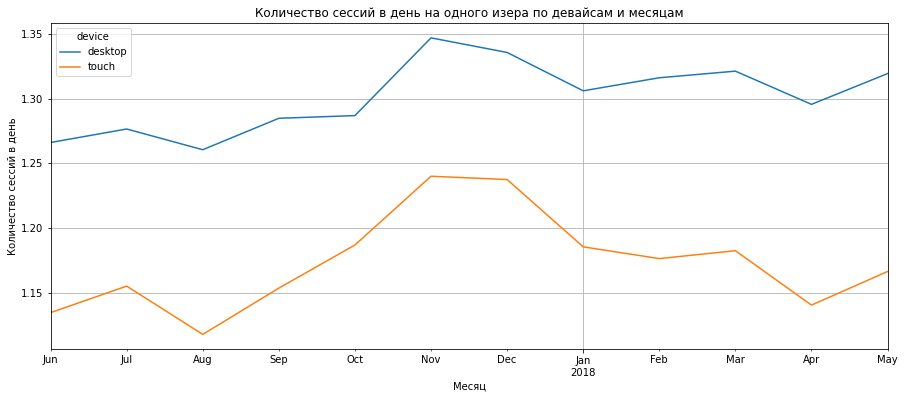

In [41]:
sessions_per_user_d.plot(figsize=(15,6))
plt.xlabel('Месяц')
plt.ylabel('Количество сессий в день')
plt.title('Количество сессий в день на одного изера по девайсам и месяцам')
plt.grid(True)
plt.xlim
plt.show()

In [42]:
sessions_per_user_d.reset_index().describe()

device,desktop,touch
count,12.000000,12.000000
mean,1.301275,1.173042
std,0.027398,0.037430
min,1.260481,1.117816
25%,1.282703,1.150272
50%,1.300768,1.171379
75%,1.319782,1.185806
max,1.346905,1.239987


<div style="border:solid black 2px; padding: 20px"> В среднем, с десктопов 1.3 сессий в день, с тачскринов - 1.2. 

In [43]:
sessions_per_user_s = visits.groupby(['session_cal_month','source_id']).agg({'uid': ['count','nunique']})
sessions_per_user_s.columns = ['n_sessions', 'n_users']
sessions_per_user_s['sessions_per_user'] = sessions_per_user_s['n_sessions'] / sessions_per_user_s['n_users']
sessions_per_user_s=sessions_per_user_s.reset_index()
sessions_per_user_s=sessions_per_user_s.pivot_table(index='session_cal_month',columns='source_id', values='sessions_per_user', aggfunc='max')
sessions_per_user_s

source_id,1,2,3,4,5,6,7,9,10
session_cal_month,,,,,,,,,
2017-06-01,1.588477,1.430157,1.049456,1.075633,1.075439,NaN,1.000000,1.092961,1.117096
2017-07-01,1.567335,1.401690,1.051131,1.070005,1.088275,1.0,1.000000,1.104982,1.079114
2017-08-01,1.575567,1.463529,1.048595,1.054011,1.081691,1.0,1.000000,1.115824,1.102459
2017-09-01,1.492473,1.420188,1.047554,1.076995,1.112936,1.0,1.000000,1.119078,1.075697
2017-10-01,1.512442,1.385672,1.056721,1.101955,1.103389,NaN,1.000000,1.117929,1.084233
2017-11-01,1.619355,1.450990,1.060059,1.120591,1.115450,1.0,1.000000,1.121640,1.189189
2017-12-01,1.607313,1.520800,1.057646,1.115127,1.115397,1.0,1.000000,1.151540,1.156200
2018-01-01,1.529879,1.482639,1.049478,1.095247,1.107180,1.0,1.000000,1.104816,1.365405
2018-02-01,1.615747,1.481165,1.055607,1.091943,1.129704,NaN,1.666667,1.083012,1.289522


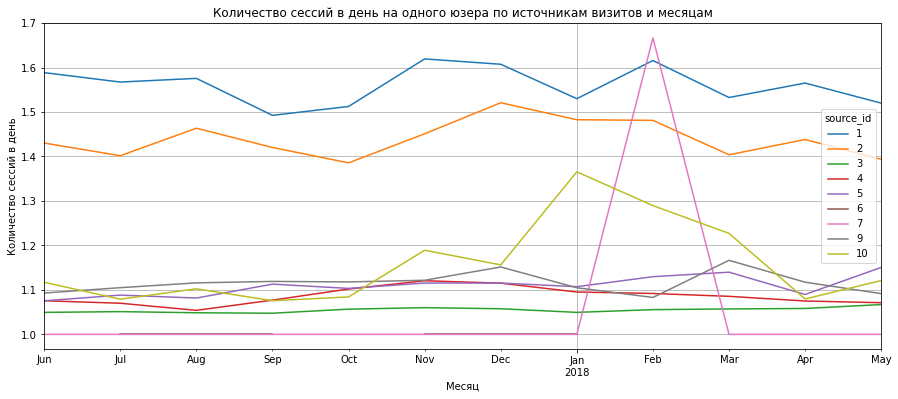

In [44]:
sessions_per_user_s.plot(figsize=(15,6))
plt.xlabel('Месяц')
plt.ylabel('Количество сессий в день')
plt.title('Количество сессий в день на одного юзера по источникам визитов и месяцам')
plt.grid(True)
plt.xlim
plt.show()

In [45]:
sessions_per_user_s.reset_index().describe().T.sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
source_id,,,,,,,,
1,12.0,1.560510,0.042733,1.492473,1.527392,1.566196,1.593186,1.619355
2,12.0,1.439374,0.041641,1.385672,1.403286,1.434138,1.467938,1.520800
10,12.0,1.157214,0.093793,1.075697,1.083075,1.119037,1.198661,1.365405
9,12.0,1.115602,0.023961,1.083012,1.101852,1.116579,1.119719,1.166479
5,12.0,1.109133,0.023183,1.075439,1.089376,1.110058,1.119013,1.150570
4,12.0,1.086107,0.019604,1.054011,1.074074,1.081269,1.096924,1.120591
7,12.0,1.055556,0.192450,1.000000,1.000000,1.000000,1.000000,1.666667
3,12.0,1.054894,0.005785,1.047554,1.049473,1.056164,1.057806,1.067004
6,6.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<div style="border:solid black 2px; padding: 20px"> В среднем, больше всего сессий с источников 1 и 2. У источника 7  был огромный пик сессий в день в начале 2018 года, с января по март. 

### Длительность одной сессии <a id="visit_duration"></a>

In [46]:
visits['session_duration_sec'] = ((visits['end_ts'] - visits['start_ts']).dt.seconds)/60
visits['session_duration_sec'].mean()

10.725108143202156

<div style="border:solid black 2px; padding: 20px"> Средняя сессия длится 10 минут. 

In [47]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_cal_month,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,2017-12-01,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,2018-02-01,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,2017-07-01,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,2018-05-01,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,2017-12-01,0.0


Посмотрим на распределение

In [48]:
duration_d = visits.groupby(['session_cal_month','device']).agg({'session_duration_sec': 'mean'})
duration_d=duration_d.reset_index()
duration_d=duration_d.pivot_table(index='session_cal_month',columns='device', values='session_duration_sec', aggfunc='mean')
duration_d

device,desktop,touch
session_cal_month,,
2017-06-01,10.786223,7.658665
2017-07-01,11.106685,7.344407
2017-08-01,10.763242,6.888456
2017-09-01,10.962345,7.279509
2017-10-01,11.139726,7.900458
2017-11-01,12.750440,9.327791
2017-12-01,12.505911,8.922364
2018-01-01,12.043452,7.907803
2018-02-01,11.842008,7.832919


In [49]:
duration_d.describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
device,,,,,,,,
desktop,12.0,11.539658,0.692390,10.763242,11.029437,11.244572,12.076249,12.750440
touch,12.0,7.828157,0.693261,6.888456,7.328183,7.745792,7.927700,9.327791


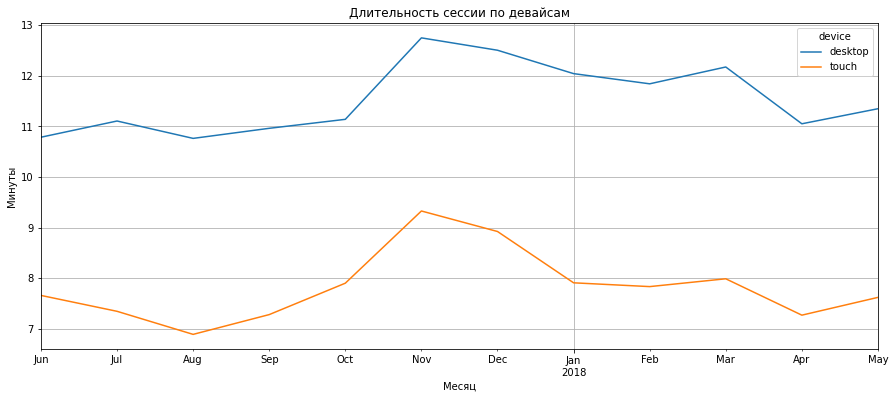

In [50]:
duration_d.plot(figsize=(15,6))
plt.xlabel('Месяц')
plt.ylabel('Минуты')
plt.title('Длительность сессии по девайсам')
plt.grid(True)
plt.xlim
plt.show()

<div style="border:solid black 2px; padding: 20px"> С десктопов сессия длится в среднем 11.5 минут, с тачскрина - почти 8 минут. Продолжительность сессий увеличивалась в конце осени, начале зимы, вокруг праздников 23 февраля и 8 марта и в начале мая. То есть пики совпадают с праздниками. 

In [51]:
duration_s = visits.groupby(['session_cal_month','source_id']).agg({'session_duration_sec': 'mean'})
duration_s=duration_s.reset_index()
duration_s=duration_s.pivot_table(index='session_cal_month',columns='source_id', values='session_duration_sec', aggfunc='mean')
duration_s

source_id,1,2,3,4,5,6,7,9,10
session_cal_month,,,,,,,,,
2017-06-01,16.301684,14.185357,8.532405,8.654257,8.205776,NaN,2.500000,7.785703,10.665898
2017-07-01,18.732744,13.945003,8.345295,8.395911,8.133970,6.0,7.000000,8.641412,9.387097
2017-08-01,18.175020,13.223758,8.445798,8.148641,8.163836,3.0,88.000000,9.199293,8.313445
2017-09-01,15.660022,13.569730,8.743702,8.988922,8.253726,0.0,13.000000,9.431350,9.819105
2017-10-01,15.925965,12.885965,9.354649,9.475297,8.528283,NaN,4.400000,9.720640,10.198157
2017-11-01,20.201992,15.080871,10.476063,10.375676,9.035828,8.0,5.000000,10.864749,11.697869
2017-12-01,17.734141,14.732235,10.480154,10.431993,9.418734,21.0,11.222222,9.550317,9.876045
2018-01-01,16.633623,15.184678,9.722249,9.262470,9.293796,99.0,7.000000,8.356952,12.877276
2018-02-01,17.599455,14.637925,9.311055,9.264824,9.022405,NaN,2.200000,9.013369,11.497957


In [52]:
duration_s.describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
source_id,,,,,,,,
6,6.0,22.833333,38.007455,0.000000,3.750000,7.000000,17.750000,99.000000
1,12.0,17.175391,1.406549,15.572936,16.067160,17.043251,17.844361,20.201992
2,12.0,13.965195,0.785827,12.885965,13.415380,13.757366,14.661502,15.184678
7,12.0,13.943519,24.196784,1.000000,2.425000,6.000000,11.666667,88.000000
10,12.0,10.544729,1.325834,8.313445,9.800020,10.139260,11.547935,12.877276
3,12.0,9.350259,0.755694,8.345295,8.690877,9.332852,9.841171,10.480154
9,12.0,9.178077,1.220178,7.742621,8.280183,9.106331,9.592898,11.780640
4,12.0,9.093240,0.740191,8.148641,8.466311,9.091504,9.317442,10.431993
5,12.0,8.706081,0.481468,8.133970,8.241738,8.750718,9.055435,9.418734


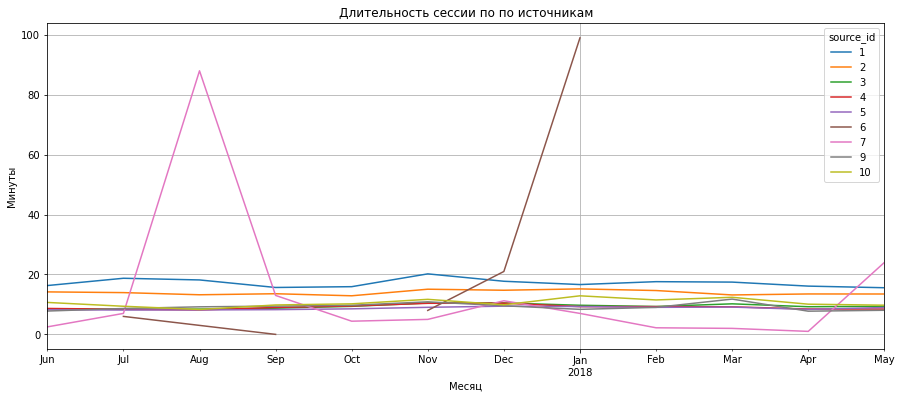

In [53]:
duration_s.plot(figsize=(15,6))
plt.xlabel('Месяц')
plt.ylabel('Минуты')
plt.title('Длительность сессии по по источникам')
plt.grid(True)
plt.xlim
plt.show()

<div style="border:solid black 2px; padding: 20px"> Дольше всего сессия длилась у посетителей с источников 1 и 2. Наблюдаются аномалии длительности сессий с источников 7 и 6: и 7 огромный скачок в августе, у 6 - в конце декабря. 

### Процент удержания пользователей <a id="visit_retention"></a>

In [54]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='uid')

In [55]:
visits.sample()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_cal_month,session_duration_sec,first_activity_date
335654,desktop,2018-03-07 17:28:00,2,2018-03-07 15:29:00,9737640335185488211,2018,3,10,2018-03-07,2018-03-01,119.0,2017-06-01 20:31:00


In [56]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')
visits.sample()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_cal_month,session_duration_sec,first_activity_date,first_activity_month,activity_month
149302,desktop,2017-10-18 11:32:00,3,2017-10-18 11:16:00,17670096023782275339,2017,10,42,2017-10-18,2017-10-01,16.0,2017-10-18 11:16:00,2017-10-01,2017-10-01


In [57]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits.sample(3)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_cal_month,session_duration_sec,first_activity_date,first_activity_month,activity_month,cohort_lifetime
151124,touch,2017-07-17 23:15:00,5,2017-07-17 22:43:00,1302956060802526672,2017,7,29,2017-07-17,2017-07-01,32.0,2017-07-06 17:02:00,2017-07-01,2017-07-01,0 days
19804,desktop,2018-03-15 10:01:00,3,2018-03-15 09:59:00,12473296794429571133,2018,3,11,2018-03-15,2018-03-01,2.0,2018-03-13 11:06:00,2018-03-01,2018-03-01,0 days
188261,desktop,2018-02-19 19:46:00,3,2018-02-19 19:18:00,10232660581407519646,2018,2,8,2018-02-19,2018-02-01,28.0,2018-02-19 19:18:00,2018-02-01,2018-02-01,0 days


In [58]:
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
visits.sample(3)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_cal_month,session_duration_sec,first_activity_date,first_activity_month,activity_month,cohort_lifetime
165911,desktop,2017-09-15 20:44:00,3,2017-09-15 20:39:00,6614141763019696301,2017,9,37,2017-09-15,2017-09-01,5.0,2017-09-15 20:39:00,2017-09-01,2017-09-01,0
144343,desktop,2018-01-11 22:08:00,3,2018-01-11 21:57:00,205739236447615536,2018,1,2,2018-01-11,2018-01-01,11.0,2018-01-11 20:42:00,2018-01-01,2018-01-01,0
58801,desktop,2017-11-28 15:19:00,5,2017-11-28 15:01:00,3562807424092797836,2017,11,48,2017-11-28,2017-11-01,18.0,2017-11-24 19:27:00,2017-11-01,2017-11-01,0


In [59]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [60]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts=cohorts.merge(initial_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


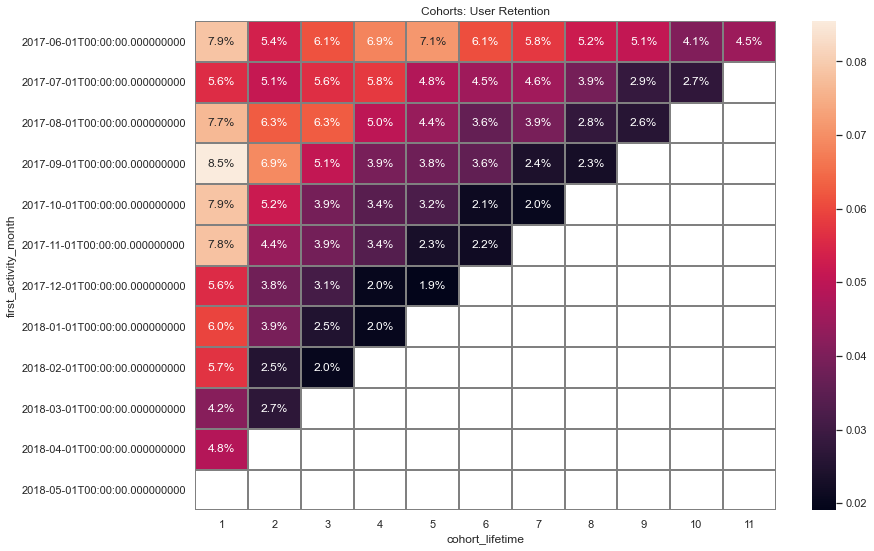

In [61]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot.drop(columns = [0]), annot=True, fmt='.1%', linewidths=1, linecolor='gray');

<div style="border:solid black 2px; padding: 20px"> Видим, что процент удержания в следующий месяц после первого визита от 4.2% до 8.5%, падает к следующему месяцу ещё в два раза. В более поздних когортах посетители возвращались ещё реже. 

Теперь посмотрим распределение по девайсам и источникам.

In [62]:
visits.sample()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_cal_month,session_duration_sec,first_activity_date,first_activity_month,activity_month,cohort_lifetime
277640,touch,2017-11-21 23:33:00,4,2017-11-21 23:33:00,15698764593478017873,2017,11,47,2017-11-21,2017-11-01,0.0,2017-11-21 23:33:00,2017-11-01,2017-11-01,0


In [63]:
users.head()

,obtain_ts,obtain_date,obtain_month,source_id,device,obtain_cost
uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6


In [64]:
visits1=visits[['uid','activity_month']]
visits1.head()

,uid,activity_month
0,16879256277535980062,2017-12-01
1,104060357244891740,2018-02-01
2,7459035603376831527,2017-07-01
3,16174680259334210214,2018-05-01
4,9969694820036681168,2017-12-01


In [65]:
retention_report=visits1.set_index('uid').join(users, how='left')[['activity_month','obtain_month','source_id','device']]
retention_report.head()

,activity_month,obtain_month,source_id,device
uid,,,,
9223535092787691177,2017-11-01,2017-11-01,1,touch
9223535092787691177,2017-11-01,2017-11-01,1,touch
9223535092787691177,2017-11-01,2017-11-01,1,touch
9223696655126052404,2017-11-01,2017-11-01,3,touch
9223707061355654945,2017-10-01,2017-10-01,9,touch


In [66]:
users.sample()

,obtain_ts,obtain_date,obtain_month,source_id,device,obtain_cost
uid,,,,,,
5299544976636036527,2018-01-24 22:57:00,2018-01-24,2018-01-01,3,touch,2.038464


In [67]:
cohorts_d_r=users.groupby(dimenstion_d).agg({'source_id':'count','obtain_cost':'sum'}).rename(columns={'source_id':'cohort_d_size'})
cohorts_d_r

,cohort_d_size,obtain_cost
device,,
desktop,160795,235065.750929
touch,67374,94000.729071


In [68]:
cohorts_s_r=users.groupby(dimenstion_s).agg({'device':'count','obtain_cost':'sum'}).rename(columns={'device':'cohort_s_size'})
cohorts_s_r

,cohort_s_size,obtain_cost
source_id,,
1,9469,20833.27
2,17616,42806.04
3,66116,141321.63
4,72346,61073.60
5,49237,51756.40
6,2,0.00
7,32,0.00
9,6448,5454.42
10,6903,5821.12


In [69]:
retention_report['cohort_lifetime']=retention_report['activity_month'] - retention_report['obtain_month']
retention_report['cohort_lifetime'] = retention_report['cohort_lifetime'] / np.timedelta64(1,'M')
retention_report['cohort_lifetime'] = retention_report['cohort_lifetime'].round().astype('int')
retention_report.head()

,activity_month,obtain_month,source_id,device,cohort_lifetime
uid,,,,,
9223535092787691177,2017-11-01,2017-11-01,1,touch,0
9223535092787691177,2017-11-01,2017-11-01,1,touch,0
9223535092787691177,2017-11-01,2017-11-01,1,touch,0
9223696655126052404,2017-11-01,2017-11-01,3,touch,0
9223707061355654945,2017-10-01,2017-10-01,9,touch,0


In [70]:
retention_report_d=retention_report.reset_index().groupby(dimenstion_d+['cohort_lifetime']).agg({'uid':'nunique'})
retention_report_d=cohorts_d_r[['cohort_d_size']].join(retention_report_d)
retention_report_d['retention'] = retention_report_d['uid']/retention_report_d['cohort_d_size']*100
retention_report_d=retention_report_d.pivot_table(index=['device'],columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_report_d=retention_report_d.drop(columns = [0])
retention_report_d

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,
desktop,6.229049,4.021891,3.228956,2.657421,2.218974,1.68351,1.298548,0.913586,0.65114,0.435337,0.295407
touch,5.638674,3.335114,2.536587,2.000772,1.555496,1.21115,0.911331,0.593701,0.39778,0.296850,0.179595


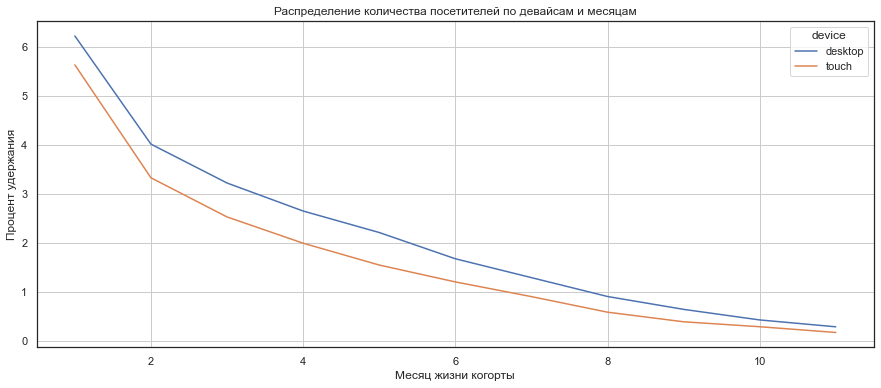

In [71]:
retention_report_d.T.plot(figsize=(15,6))
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Процент удержания')
plt.title('Распределение количества посетителей по девайсам и месяцам')
plt.grid(True)
plt.xlim
plt.show()

<div style="border:solid black 2px; padding: 20px">  Десктопы удерживают больше посетителей примерно на 1%.

In [72]:
retention_report_s=retention_report.reset_index().groupby(dimenstion_s+['cohort_lifetime']).agg({'uid':'nunique'})
retention_report_s=cohorts_s_r[['cohort_s_size']].join(retention_report_s)
retention_report_s['retention'] = retention_report_s['uid']/retention_report_s['cohort_s_size']*100
retention_report_s=retention_report_s.pivot_table(index=['source_id'],columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_report_s=retention_report_s.drop(columns = [0])
retention_report_s

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,
1,10.074982,5.966839,4.340479,3.558982,2.914775,2.460661,1.879818,1.415144,1.045517,0.855423,0.623086
2,9.542461,6.255677,5.313351,4.637829,3.786331,2.974569,2.446639,1.799500,1.282925,0.976385,0.641462
3,6.052998,3.846270,3.127836,2.545526,1.975316,1.532156,1.194870,0.828846,0.550548,0.347873,0.228386
4,5.408730,3.345036,2.669118,2.047107,1.751306,1.271667,0.950986,0.598513,0.442319,0.320681,0.201808
5,4.401162,2.662632,1.986311,1.620732,1.344517,1.050023,0.763653,0.548368,0.355424,0.217316,0.127953
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,3.125000,3.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,11.569479,8.917494,6.761787,6.234491,5.241935,3.582506,2.977667,2.264268,1.674938,0.992556,0.744417
10,5.099232,2.853832,2.028104,1.492105,1.448646,1.231349,0.680863,0.304216,0.333188,0.202810,0.231783


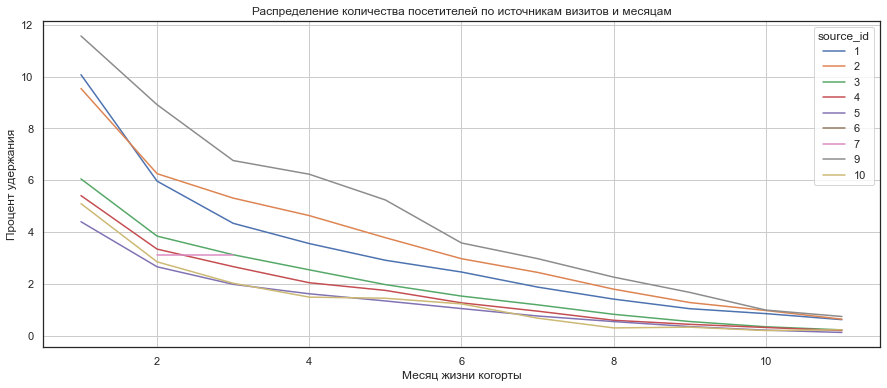

In [73]:
retention_report_s.T.plot(figsize=(15,6))
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Процент удержания')
plt.title('Распределение количества посетителей по источникам визитов и месяцам')
plt.grid(True)
plt.xlim
plt.show()

<div style="border:solid black 2px; padding: 20px">  Чаще возвращаются люди, пришедшие из источников 1, 2 и 9.

## Продажи <a id="orders"></a>

### Когда люди начинают покупать <a id="orders_delta"></a>

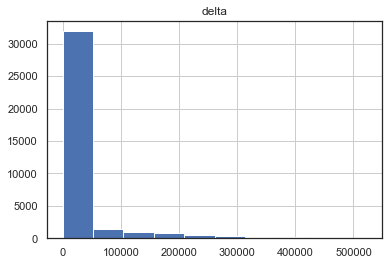

In [74]:
first_visits = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid') \
                     .agg({'start_ts' : 'first', 'source_id': 'first', 'device': 'first'})
first_orders = orders.sort_values(by = ['uid', 'buy_ts']).groupby('uid') \
                     .agg({'buy_ts' : 'first'})
report_purchase_time = first_visits.merge(first_orders, on = 'uid')
report_purchase_time['delta'] = (report_purchase_time['buy_ts'] - report_purchase_time['start_ts']).dt.total_seconds() / 60 # минуты 
report_purchase_time[['delta']].hist()
plt.show()

In [75]:
report_purchase_time[['delta']].describe()

,delta
count,36523.000000
mean,24340.175834
std,67784.774690
min,0.000000
25%,4.000000
50%,16.000000
75%,2897.000000
max,523144.000000


<div style="border:solid black 2px; padding: 20px"> Медианное значение времени между первым визитом и первой покупкой составляет 16 минут. Возьмем медиану, чтобы не учитывать большие выбросы. 

Посмотрим на данные в разрезе источников и девайсов. 

In [76]:
report_purchase_time_d=first_visits.merge(first_orders, on = 'uid')
report_purchase_time_d['delta'] = (report_purchase_time_d['buy_ts'] - report_purchase_time_d['start_ts']).dt.total_seconds() / 60
report_purchase_time_d=report_purchase_time_d.groupby('device').agg({'delta':'median'})
report_purchase_time_d

,delta
device,
desktop,15.0
touch,38.0


<div style="border:solid black 2px; padding: 20px"> Пользователи на десктопах покупают обычно через 15 минут после первого визита, а с тачскринов - через 38 минут. 

In [77]:
report_purchase_time_s=first_visits.merge(first_orders, on = 'uid')
report_purchase_time_s['delta'] = (report_purchase_time_s['buy_ts'] - report_purchase_time_s['start_ts']).dt.total_seconds() / 60
report_purchase_time_s=report_purchase_time_s.groupby('source_id').agg({'delta':'median'})
report_purchase_time_s.sort_values(by='delta')

,delta
source_id,
1,10.0
5,11.0
10,12.0
4,18.0
3,19.0
2,23.0
7,52.0
9,4471.5


<div style="border:solid black 2px; padding: 20px"> Быстрее всего покупают с источников 1,5 и 10: 10, 11 и 12 минут соответственно. 

### Количество покупок за период <a id="orders_count"></a>

In [78]:
orders.sample()

,buy_ts,revenue,uid
21060,2017-11-30 09:50:00,6.11,7953376971237044409


In [79]:
orders['order_month']=orders['buy_ts'].dt.month
orders['order_year']=orders['buy_ts'].dt.year
orders['order_cal_month']=orders['buy_ts'].astype('datetime64[M]')
orders.sample()

,buy_ts,revenue,uid,order_month,order_year,order_cal_month
26187,2017-12-26 15:16:00,3.85,13888745432979765063,12,2017,2017-12-01


In [80]:
first_order_date = orders.groupby(['uid'])['buy_ts'].min()
first_order_date.name = 'first_order_date'
orders= orders.join(first_order_date,on='uid')
orders.head()

,buy_ts,revenue,uid,order_month,order_year,order_cal_month,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,6,2017,2017-06-01,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,6,2017,2017-06-01,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,6,2017,2017-06-01,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,6,2017,2017-06-01,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,6,2017,2017-06-01,2017-06-01 07:58:00


In [81]:
orders_per_user=orders.groupby(['order_cal_month']).agg({'uid': ['count','nunique']})   
orders_per_user.columns = ['n_sessions', 'n_users']
orders_per_user['orders_per_user'] = orders_per_user['n_sessions'] / orders_per_user['n_users']
orders_per_user

,n_sessions,n_users,orders_per_user
order_cal_month,,,
2017-06-01,2354,2023,1.163618
2017-07-01,2363,1984,1.191028
2017-08-01,1807,1472,1.227582
2017-09-01,3387,2750,1.231636
2017-10-01,5679,4675,1.214759
2017-11-01,5659,4547,1.244557
2017-12-01,6218,4942,1.258195
2018-01-01,4721,3898,1.211134
2018-02-01,5281,4258,1.240254


In [82]:
orders_per_user['orders_per_user'].mean()

1.2058233446244648

<div style="border:solid black 2px; padding: 20px"> Поceтитель покупает на афише в среднем чуть больше одного раза в месяц. 

### Средний чек <a id="orders_mean"></a>

In [83]:
orders.sample()

,buy_ts,revenue,uid,order_month,order_year,order_cal_month,first_order_date
13744,2017-10-20 14:52:00,9.78,13771897229304902390,10,2017,2017-10-01,2017-10-18 23:01:00


In [84]:
mean_order=orders['revenue'].sum()/orders['uid'].nunique()
mean_order

6.9013279303452615

<div style="border:solid black 2px; padding: 20px"> Средний чек по всем уникальным пользователям за весь период составляет примерно 7 у.е. 

In [85]:
mean_order=orders['revenue'].sum()/len(orders) # или делить на orders['uid'].count()
mean_order

4.999646930477041

In [86]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   buy_ts            50415 non-null  datetime64[ns]
 1   revenue           50415 non-null  float64       
 2   uid               50415 non-null  uint64        
 3   order_month       50415 non-null  int64         
 4   order_year        50415 non-null  int64         
 5   order_cal_month   50415 non-null  datetime64[ns]
 6   first_order_date  50415 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(2), uint64(1)
memory usage: 2.7 MB


In [87]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

Сперва сгруппируем данные по когорте first_order_month и месяцу совершения заказа order_month:

In [88]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_by_cohorts.head()

revenue   uid
first_order_month order_month               
2017-06-01        2017-06-01   9557.49  2023
                  2017-07-01    981.82    61
                  2017-08-01    885.34    50
                  2017-09-01   1931.30    54
                  2017-10-01   2068.58    88

Найдём средний чек покупателя revenue_per_user — разделим показатель revenue на uid. Потом построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, как изменяется средний чек с течением времени:

In [89]:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean') 

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


Посмотрим показатели когорт по времени жизни

In [90]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
orders_grouped_by_cohorts['first_order_month'].dt.strftime('%d.%m.%Y') 
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m') 
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')
revenue_per_user_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


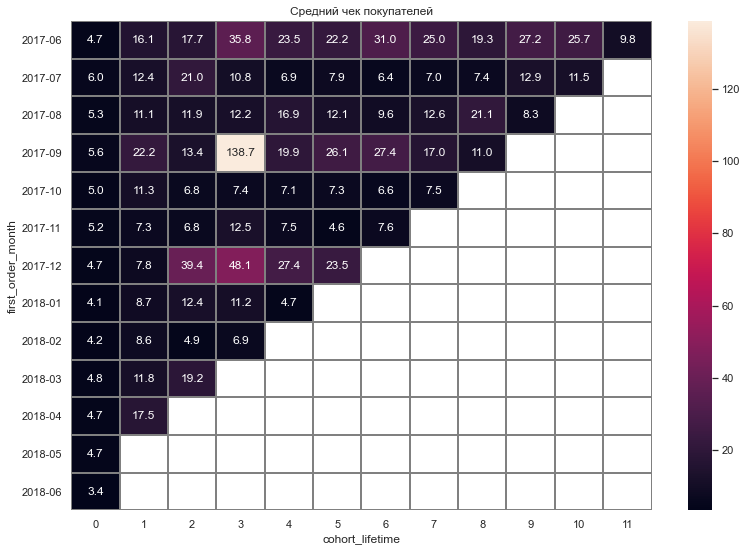

In [91]:
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray') 
plt.show()

Средний чек возрастает на второй месяц в 2-4 раза. Выделилась сентябрьская когорта с большим средним чеком на третий месяц, как раз перед новым годом. Большие средние чеки были у декабрьской когорты. 

### Доход с пользователя (LTV) <a id="orders_ltv"></a>

In [92]:
orders.sample()

,buy_ts,revenue,uid,order_month,order_year,order_cal_month,first_order_date,first_order_month
39337,2018-03-10 18:55:00,3.05,17919494110496493520,2018-03-01,2018,2018-03-01,2018-03-10 18:55:00,2018-03-01


In [93]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [94]:
ltv_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
ltv_cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [95]:
ltv_report=pd.merge(cohort_sizes, ltv_cohorts, on='first_order_month')
ltv_report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [96]:
ltv_report['age'] = (ltv_report['order_month'] - ltv_report['first_order_month']) / np.timedelta64(1, 'M')
ltv_report['age'] = ltv_report['age'].round().astype('int')
ltv_report.head()

,first_order_month,n_buyers,order_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


In [97]:
ltv_report['ltv'] = ltv_report['revenue'] / ltv_report['n_buyers']
ltv_report.rename(columns={'first_order_month':'obtain_month'})

,obtain_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,1,0.531599
77,2018-05-01,2988,2018-05-01,13925.76,0,4.660562


In [98]:
output_ltv = ltv_report.pivot_table(
       index='first_order_month', 
      columns='age', 
      values='ltv', 
      aggfunc='mean').round(2).cumsum(axis=1)
output_ltv.fillna('') 
output_ltv.append(pd.DataFrame(output_ltv.mean().to_frame(name='Total')).T).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
2017-06-01 00:00:00,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01 00:00:00,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,NaN
2017-08-01 00:00:00,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,NaN,NaN
2017-09-01 00:00:00,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,NaN,NaN,NaN
2017-10-01 00:00:00,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01 00:00:00,5.15,5.55,5.75,6.07,6.22,6.27,6.38,NaN,NaN,NaN,NaN,NaN
2017-12-01 00:00:00,4.74,5.00,5.93,7.00,7.31,7.65,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:00:00,4.14,4.43,4.73,4.87,4.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01 00:00:00,4.16,4.44,4.52,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:00:00,4.84,5.14,5.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


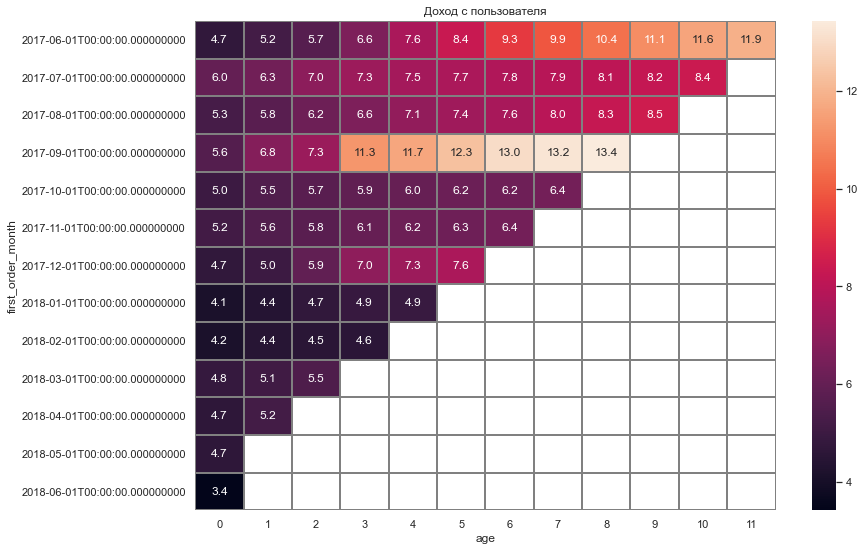

In [99]:
plt.figure(figsize=(13, 9))
plt.title('Доход с пользователя')
sns.heatmap(output_ltv, annot=True, fmt='.1f', linewidths=1, linecolor='gray') 
plt.show()

<div style="border:solid black 2px; padding: 20px"> Первый месяц доход с пользователя составлял 4.5 у.е. Максимум составлял 13.5 у.е. Июньская и сентябрьская когорта оказалась самой прибыльной. 

In [100]:
output_ltv.append(pd.DataFrame(output_ltv.mean().to_frame(name='Total')).T).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
2017-06-01 00:00:00,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01 00:00:00,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,NaN
2017-08-01 00:00:00,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,NaN,NaN
2017-09-01 00:00:00,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,NaN,NaN,NaN
2017-10-01 00:00:00,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01 00:00:00,5.15,5.55,5.75,6.07,6.22,6.27,6.38,NaN,NaN,NaN,NaN,NaN
2017-12-01 00:00:00,4.74,5.00,5.93,7.00,7.31,7.65,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:00:00,4.14,4.43,4.73,4.87,4.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01 00:00:00,4.16,4.44,4.52,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:00:00,4.84,5.14,5.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим данные сгрупированные по девайсу и источнику визитов.

In [101]:
users.head()

,obtain_ts,obtain_date,obtain_month,source_id,device,obtain_cost
uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6


In [102]:
costs=costs.rename(columns={'dt':'obtain_date'})
costs.sample()

,source_id,obtain_date,costs
244,1,2018-01-31,97.7


In [103]:
users=(visits.sort_values(by=['uid','start_ts']).groupby('uid')
             .agg({'start_ts':'first','source_id':'first','device':'first'})
      .rename(columns={'start_ts':'obtain_ts'}))
users['obtain_date']=users['obtain_ts'].dt.date
users['obtain_month']=users['obtain_ts'].astype('datetime64[M]')
users=(users.reset_index().set_index(['source_id','obtain_date'])
       .join(costs.set_index(['source_id','obtain_date']), how='left'))
users.head()

uid           obtain_ts   device  \
source_id obtain_date                                                     
1         2017-06-01    469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01    618675438905551322 2017-06-01 02:37:00    touch   
          2017-06-01   1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01   1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01   1548840741623289234 2017-06-01 01:18:00  desktop   

                      obtain_month  costs  
source_id obtain_date                      
1         2017-06-01    2017-06-01   75.2  
          2017-06-01    2017-06-01   75.2  
          2017-06-01    2017-06-01   75.2  
          2017-06-01    2017-06-01   75.2  
          2017-06-01    2017-06-01   75.2

In [104]:
user_cost=(users.groupby(['source_id','obtain_date']).agg({'device':'count','costs':'mean'})
           .rename(columns={'device':'users'}))
user_cost['obtain_cost']=user_cost['costs']/user_cost['users']
users=users.join(user_cost[['obtain_cost']], how = 'left')
users=users.reset_index().set_index('uid')[['obtain_ts','obtain_date','obtain_month','source_id','device','obtain_cost']]
users.head()

,obtain_ts,obtain_date,obtain_month,source_id,device,obtain_cost
uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6


In [105]:
dimenstion_d=['device']
cohorts_d_cost=users.groupby(dimenstion_d).agg({'source_id':'count','obtain_cost':'max'}).rename(columns={'source_id':'cohort_d_size'})
cohorts_d_cost

,cohort_d_size,obtain_cost
device,,
desktop,160795,19.92
touch,67374,16.33


In [106]:
dimenstion_s=['source_id']
cohorts_s_cost=users.groupby(dimenstion_s).agg({'device':'count','obtain_cost':'max'}).rename(columns={'device':'cohort_s_size'})
cohorts_s_cost

,cohort_s_size,obtain_cost
source_id,,
1,9469,12.510000
2,17616,5.276286
3,66116,5.122635
4,72346,3.462326
5,49237,3.408000
6,2,NaN
7,32,NaN
9,6448,19.920000
10,6903,12.100000


In [107]:
ltv=orders.set_index('uid').join(users, how='left')[['obtain_month','source_id','device','order_month','revenue']]
ltv['age_month']=((ltv['order_month']-ltv['obtain_month'])/np.timedelta64(1,'M')).round().astype('int')
ltv_d=ltv.groupby(dimenstion_d + ['age_month']).agg({'revenue':'sum'})
ltv_d=ltv_d.pivot_table(index=['device'],columns='age_month',values='revenue',aggfunc='sum')
ltv_d=ltv_d.cumsum(axis=1)
ltv_d=cohorts_d_cost[['cohort_d_size']].join(ltv_d)
ltv_d=ltv_d.div(ltv_d['cohort_d_size'],axis=0).drop(columns=['cohort_d_size'])
ltv_d

,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,0.728664,0.843359,0.924280,1.069796,1.130539,1.182688,1.219687,1.246150,1.266860,1.288880,1.303720,1.314281
touch,0.373185,0.446775,0.478607,0.502507,0.521153,0.538848,0.551608,0.569115,0.583387,0.596858,0.601088,0.604498


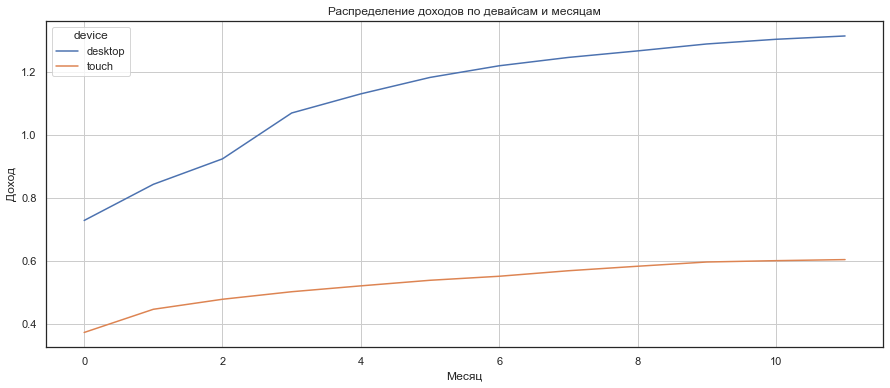

In [108]:
ltv_d.T.plot(figsize=(15,6))
plt.xlabel('Месяц')
plt.ylabel('Доход')
plt.title('Распределение доходов по девайсам и месяцам')
plt.grid(True)
plt.xlim
plt.show()


<div style="border:solid black 2px; padding: 20px"> Пользователи тратят деньги с десктопов в два раза больше, чем с тачскрин-девайсов.

In [109]:
ltv_s=ltv.groupby(dimenstion_s + ['age_month']).agg({'revenue':'sum'})
ltv_s=ltv_s.pivot_table(index=['source_id'],columns='age_month',values='revenue',aggfunc='sum')
ltv_s=ltv_s.cumsum(axis=1)
ltv_s=cohorts_s_cost[['cohort_s_size']].join(ltv_s)
ltv_s=ltv_s.div(ltv_s['cohort_s_size'],axis=0).drop(columns=['cohort_s_size'])
ltv_s

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,1.534161,1.810219,1.999839,2.288663,2.467350,2.585022,2.683702,2.916896,3.049194,3.141014,3.227996,3.283404
2,1.016428,1.360377,1.703597,2.072417,2.253705,2.394160,2.463452,2.507828,2.550502,2.604603,2.641813,2.663693
3,0.570372,0.659824,0.697257,0.731096,0.761171,0.782027,0.798246,0.807016,0.814781,0.819245,0.822212,0.824479
4,0.517687,0.579292,0.608671,0.637434,0.661811,0.691519,0.720278,0.730149,0.743284,0.762166,0.773152,0.783690
5,0.584571,0.654081,0.695008,0.915836,0.951518,0.995270,1.018674,1.037467,1.048500,1.064406,1.067149,1.068790
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.038125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.368263,0.466126,0.554842,0.633721,0.704563,0.739634,0.782604,0.813542,0.856348,0.881770,0.890800,0.893207
10,0.514917,0.558789,0.577229,0.588343,0.613280,0.624930,0.635299,0.639061,0.639681,0.642244,0.643377,0.644695


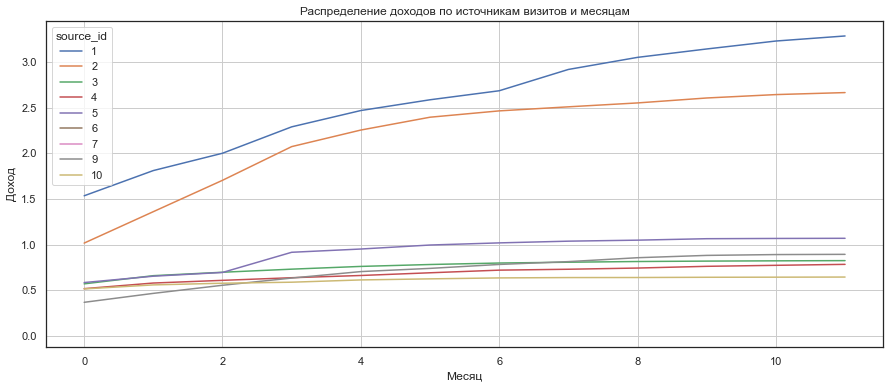

In [110]:
ltv_s.T.plot(figsize=(15,6))
plt.xlabel('Месяц')
plt.ylabel('Доход')
plt.title('Распределение доходов по источникам визитов и месяцам')
plt.grid(True)
plt.xlim
plt.show()
plt.show()

<div style="border:solid black 2px; padding: 20px"> Пользователи с источников 1 и 2 приносят дохода больше, чем с остальных в два-три раза. 

## Маркетинг <a id="marketing"></a>

### Траты суммарные / на каждый источник / по времени <a id="marketing_costs"></a>

In [111]:
costs.sample()

,source_id,obtain_date,costs
2145,9,2018-04-28,11.68


In [112]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   source_id    2542 non-null   int64         
 1   obtain_date  2542 non-null   datetime64[ns]
 2   costs        2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [113]:
costs_total_sum=costs['costs'].sum()
costs_total_sum

329131.62

<div style="border:solid black 2px; padding: 20px"> Всего было потрачено 329131 уе. 

In [114]:
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10], dtype=int64)

In [115]:
cost_source=costs.pivot_table(index='source_id',values='costs', aggfunc='sum')
cost_source.sort_values(by='costs', ascending=False)

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


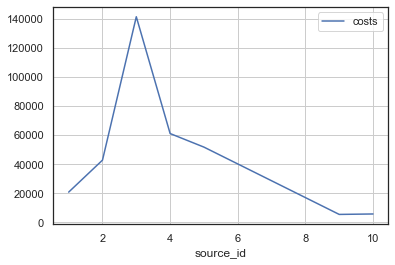

In [116]:
cost_source.plot(grid=True)
plt.show()

<div style="border:solid black 2px; padding: 20px"> Больше всего было потрачено на источники 3, 4 и 5. Меньше всего на 9 и 10. 

In [117]:
costs.sample()

,source_id,obtain_date,costs
1468,5,2017-06-17,63.85


In [118]:
costs1=costs
costs1['costs_month']=costs['obtain_date'].astype('datetime64[M]')
costs1.head() 

,source_id,obtain_date,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [119]:
costs_months=costs1.pivot_table(index='costs_month',values='costs', aggfunc='sum')
costs_months.reset_index()
costs_months.sort_values(by='costs', ascending=False)

,costs
costs_month,
2017-12-01,38315.35
2017-11-01,37907.88
2017-10-01,36322.88
2018-01-01,33518.52
2018-02-01,32723.03
2018-03-01,30415.27
2017-09-01,24368.91
2018-04-01,22289.38
2018-05-01,22224.27


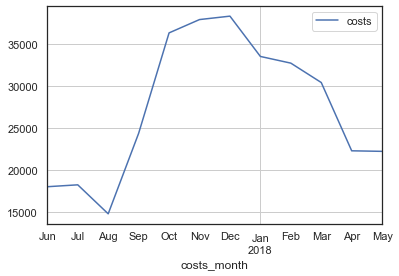

In [120]:
costs_months.plot(grid=True)
plt.show()

<div style="border:solid black 2px; padding: 20px"> Пик трат пришёлся октябрь, ноябрь, декабрь 2017 года. Меньше всего трат было в августе.

In [121]:
costs1.pivot_table(index='costs_month',
               columns='source_id',
               values='costs',
               aggfunc='sum')

source_id,1,2,3,4,5,9,10
costs_month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


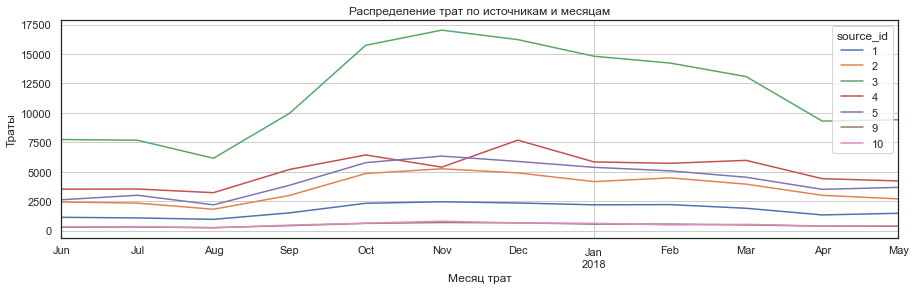

In [122]:
fig, ax=plt.subplots(figsize=(15,4))
pd.pivot_table(costs1,
               index='costs_month',
               columns='source_id',
               values='costs',
               aggfunc='sum').plot(ax=ax)
plt.xlabel('Месяц трат')
plt.ylabel('Траты')
plt.title('Распределение трат по источникам и месяцам')
plt.grid(True)
plt.xlim
plt.show()

<div style="border:solid black 2px; padding: 20px"> График нагляднее показывает, что больше всего было потрачено на источник номер 3, пики всех источников более-менее совпадают: в августе меньше всего, больше всего в последнем квартале 2017 года. 

### Cтоимость привлечения одного покупателя из каждого источника (CAC) <a id="marketing_cac"></a>

Посчитаем расходы на месяц

In [123]:
users.head()

,obtain_ts,obtain_date,obtain_month,source_id,device,obtain_cost
uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6


In [124]:
costs.head()

,source_id,obtain_date,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [125]:
cac_s=users.groupby(dimenstion_s).agg({'obtain_cost':'sum'})
cac_s=cohorts_s_cost[['cohort_s_size']].join(cac_s)
cac_s['cac']=(cac_s['obtain_cost']/cac_s['cohort_s_size']).round(2)
cac_s

,cohort_s_size,obtain_cost,cac
source_id,,,
1,9469,20833.27,2.20
2,17616,42806.04,2.43
3,66116,141321.63,2.14
4,72346,61073.60,0.84
5,49237,51756.40,1.05
6,2,0.00,0.00
7,32,0.00,0.00
9,6448,5454.42,0.85
10,6903,5821.12,0.84


<div style="border:solid black 2px; padding: 20px">  Больше всего трат пришлось на привлечение посетителей из источников 1,2 и 3.
    
    1 - 2.2 за посетителя 
    2 - 2.4 за посетителя
    3 - 2.1 за посетителя

In [126]:
cac_s['cac'].mean()

1.1500000000000001

### Окупаемость расходов (ROI) <a id="marketing_roi"></a>

In [127]:
cost_source=cohorts_s_cost[['cohort_s_size']].join(cost_source)
cost_source=cost_source.reset_index()
cost_source_per_user=cost_source
cost_source_per_user['cac']=cost_source['costs']/cost_source['cohort_s_size']
cost_source_per_user=cost_source_per_user.reset_index().set_index('source_id')
cost_source_per_user

,index,cohort_s_size,costs,cac
source_id,,,,
1,0,9469,20833.27,2.200155
2,1,17616,42806.04,2.429952
3,2,66116,141321.63,2.137480
4,3,72346,61073.60,0.844188
5,4,49237,51757.10,1.051183
6,5,2,NaN,NaN
7,6,32,NaN,NaN
9,7,6448,5517.49,0.855690
10,8,6903,5822.49,0.843472


In [128]:
visits['uid'].nunique()

228169

In [129]:
cost_source_per_user['cohort_s_size'].sum()

228169

In [130]:
f'Количество покупателей: {orders.uid.nunique()}'

'Количество покупателей: 36523'

In [131]:
roi_report=ltv_s.merge(cost_source_per_user[['cac']], on = 'source_id', how = 'left')
roi_report=roi_report.div(roi_report['cac'],axis=0).drop(columns=['cac'])
roi_report=roi_report.cumsum(axis=1)
roi_report

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.697297,1.520065,2.429019,3.469247,4.590691,5.765618,6.985396,8.311164,9.697064,11.124697,12.591864,14.084215
2,0.418291,0.978129,1.679211,2.532074,3.459543,4.444814,5.458600,6.490648,7.540258,8.612132,9.699319,10.795511
3,0.266843,0.575536,0.901741,1.243777,1.599884,1.965748,2.339200,2.716755,3.097943,3.481219,3.865883,4.251607
4,0.613237,1.299449,2.020463,2.775549,3.559511,4.378664,5.231884,6.096798,6.977270,7.880110,8.795963,9.724299
5,0.556108,1.178341,1.839508,2.710751,3.615938,4.562748,5.531822,6.518774,7.516222,8.528800,9.543989,10.560739
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.430370,0.975106,1.623521,2.364117,3.187502,4.051873,4.966461,5.917205,6.917974,7.948451,8.989483,10.033327
10,0.610472,1.272959,1.957307,2.654832,3.381921,4.122822,4.876017,5.633672,6.392063,7.153491,7.916263,8.680597


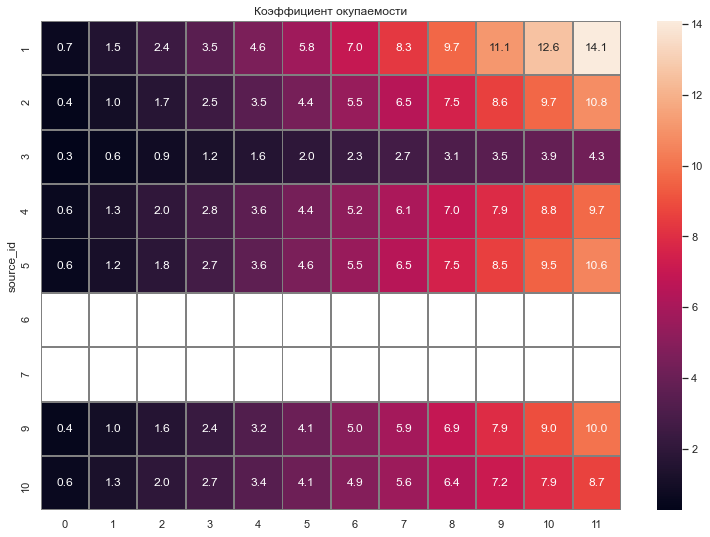

In [132]:
plt.figure(figsize=(13, 9))
plt.title('Коэффициент окупаемости')
sns.heatmap(roi_report, annot=True, fmt='.1f', linewidths=1, linecolor='gray') 
plt.show()

<div style="border:solid black 2px; padding: 20px"> Пользователи выходят на окупаемость на второй месяц. Больше всего прибыль приносят пользователи из источника 1,2 и 5. 

# Выводы <a id="resume"></a>

**Продукт**

- **Сколько людей пользуются в день, неделю, месяц?**
 
В среднем ресурс посещают 23 тысячи человек в месяц, ~5700 - каждую неделю, ~ 900 - ежедневно. Афишей пользуются с десктопов в 2.5 раза больше чем с телефонов и планшетов. Источники 4,3 и 5 - самые популярные, реже всего приходят из источников 6 и 7. Пик посещаемости был в конце осени-начале зимы - больше 40 000 посетителей (гулять на улице холодно, на носу всякие праздники).
   - **Сколько сессий в день?**
 
В среднем на афише бывает около 1000 сессий в день: 70% с десктопов и 30% с тачскринов. Больше всего сессий сделано пользователями, пришедших из источников 3 и 4.

   -	**Сколько длится одна сессия?**
  
Средняя сессия длится 10 минут. С десктопов сессия длится в среднем 11.5 минут, с тачскрина - почти 8 минут. Продолжительность сессий увеличивалась в конце осени, начале зимы, вокруг праздников 23 февраля и 8 марта и в начале мая. То есть пики совпадают с праздниками. Дольше всего сессия длилась у посетителей с источников 1 и 2. Наблюдаются аномалии длительности сессий с источников 7 и 6: и 7 огромный скачок в августе, у 6 - в конце декабря.

 - **Как часто люди возвращаются?**
 
Процент удержания в следующий месяц после первого визита от 4.2% до 8.5%, падает к следующему месяцу ещё в два раза. В более поздних когортах посетители возвращались ещё реже. Посетители с десктопов задерживаются больше посетителей с тачскринов примерно на 1%. Чаще возвращаются люди, пришедшие из источников 1, 2 и 9.

**Продажи**

- **Когда люди начинают покупать?**

Среднее время между первым визитом и покупкой составляет 16 минут. Пользователи на десктопах покупают обычно через 15 минут после первого визита, а с тачскринов - через 38 минут. Быстрее всего покупают с источников 1,5 и 10: 10, 11 и 12 минут соответственно.

- **Сколько раз покупают за период?**

Посетитель покупает на афише в среднем чуть больше одного раза в месяц.

- **Какой средний чек?**

Средний чек по всем уникальным пользователям за весь период составляет примерно 7 у.е. Средний чек возрастает на второй месяц в 2-4 раза. Выделилась сентябрьская когорта с большим средним чеком на третий месяц, как раз перед новым годом. Большие средние чеки были у декабрьской когорты.

- **Сколько денег приносят? (LTV)**

Первый месяц доход с пользователя составлял 4.5 у.е. Максимум составлял 13.5 у.е. Июньская и сентябрьская когорта оказалась самой прибыльной. Пользователи тратят деньги с десктопов в два раза больше, чем с тачскрин-девайсов. Пользователи с источников 1 и 2 приносят дохода больше, чем с остальных в два-три раза.

**Маркетинг**

- **Сколько денег потратили? Всего / на каждый источник / по времени**

Всего было потрачено 329131 уе. Больше всего было потрачено на источники 3, 4 и 5. Меньше всего на 9 и 10. Пик трат пришёлся октябрь, ноябрь, декабрь 2017 года. Меньше всего трат было в августе.

- **Сколько стоило привлечение одного покупателя из каждого источника?**

Расходов на пользователей с десктопов в два раза больше, чем на пользователей тачскринов. Десктоп - 0.39, тачскрин - 0.21. Больше всего трат пришлось на привлечение посетителей из источников 1,2 и 3. 1 - 2.2 за посетителя, 2 - 2.4 , 3 - 2.1.

- **На сколько окупились расходы? (ROI)**

Пользователи вышли на окупаемость на второй месяц. Больше всего прибыль приносят пользотели из источника 1,2 и 5.


# Рекомендации <a id="recommendations"></a>

Источники 1 и 2 покупают много, возвращаются больше других и хорошо окупаются. 
Источники 3 и 4 - одни из самых популярных, но плохо окупаются, так что не стоит тратить на них дополнительный бюджет. 
Источник 5 окупается, но медленно. 
Источник 6 и 7 не дает значительной информации. 
Источники 9 и 10 приносят доход медленно. 

Рекламный бюджет следует делить между 1 и 2 источниками. Так как у первого источника лучше окупаемость, предлагаем больший приоритет отдать в первый сектор. 